In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing data
fraud_data_df = pd.read_csv(r"Fraud_check.csv")

In [3]:
fraud_data_df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [4]:
fraud_data_df.shape

(600, 6)

In [5]:
# Checking datatypes
fraud_data_df.dtypes

Undergrad          object
Marital.Status     object
Taxable.Income      int64
City.Population     int64
Work.Experience     int64
Urban              object
dtype: object

In [6]:
# Checking dupliacte values
fraud_data_df[fraud_data_df.duplicated()]

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


In [7]:
# Finding Missing Values
nan_bool_df = fraud_data_df.isna()

# Use sum() to count the number of True values (NaN) in each column
nan_count_per_column = nan_bool_df.sum()

# If you want the total count of NaN values in the entire DataFrame, you can sum the nan_count_per_column
total_nan_count = nan_count_per_column.sum()

nan_count_per_column

total_nan_count

0

In [8]:
fraud_data_df.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


### In the next step the dataframe is split into two dataframes namely continuous variable dataframe and categorical variable dataframe.
### Continuous variable dataframe will be checked for multicollinearity and kind of distribution each variable has. Based on the distribution either normalization or the standardization will be applied.
### Categorical variable dataframe will undergo one hot encoder and label encoder for the categorical variables.
### These dataframes will be mearged after these pre processing steps.
## Splitting of dataframe. 

In [9]:
fraud_data_df.head(1)

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES


In [10]:
# Dataframe to check the outliers for the continuous variable.

cont_df = fraud_data_df[['City.Population', 'Work.Experience']]
cat_df = fraud_data_df[['Undergrad', 'Marital.Status', 'Urban', 'Taxable.Income']]

### Pre-processing of training continuous variable dataframe.

In [11]:
cont_df

,City.Population,Work.Experience
0,50047,10
1,134075,18
2,160205,30
3,193264,15
4,27533,28
...,...,...
595,39492,7
596,55369,2
597,154058,0
598,180083,17


### Using Box Plot to detect the outliers

Indices of outliers from the box plots:
[]
0


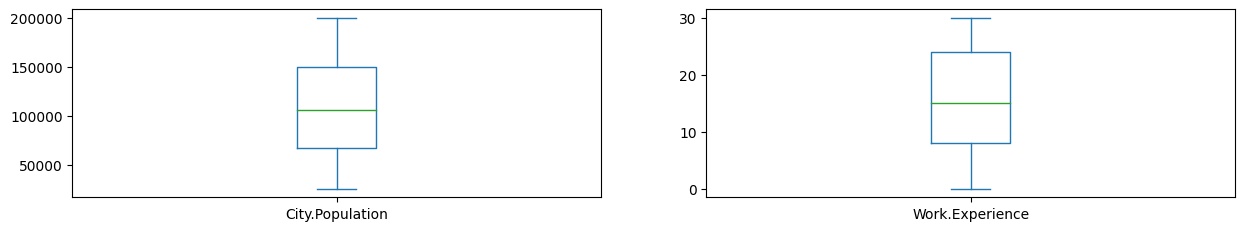

In [12]:
# Box plot find the outliers 

box_plot = cont_df.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

# Calculate the IQR for each variable
Q1 = cont_df.quantile(0.25)
Q3 = cont_df.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Get the indices of the outliers
outlier_indices = []

for col, ax in zip(cont_df.columns, box_plot):
    outliers = ((cont_df[col] < (Q1[col] - IQR_multiplier * IQR[col])) | (cont_df[col] > (Q3[col] + IQR_multiplier * IQR[col])))
    col_outlier_indices = cont_df.index[outliers]
    outlier_indices.extend(col_outlier_indices)

outlier_indices = list(set(outlier_indices))  # Remove duplicate indices

# Display the outlier indices
print("Indices of outliers from the box plots:")
print(outlier_indices)
print(len(outlier_indices))

### Using IQR to detect the outliers

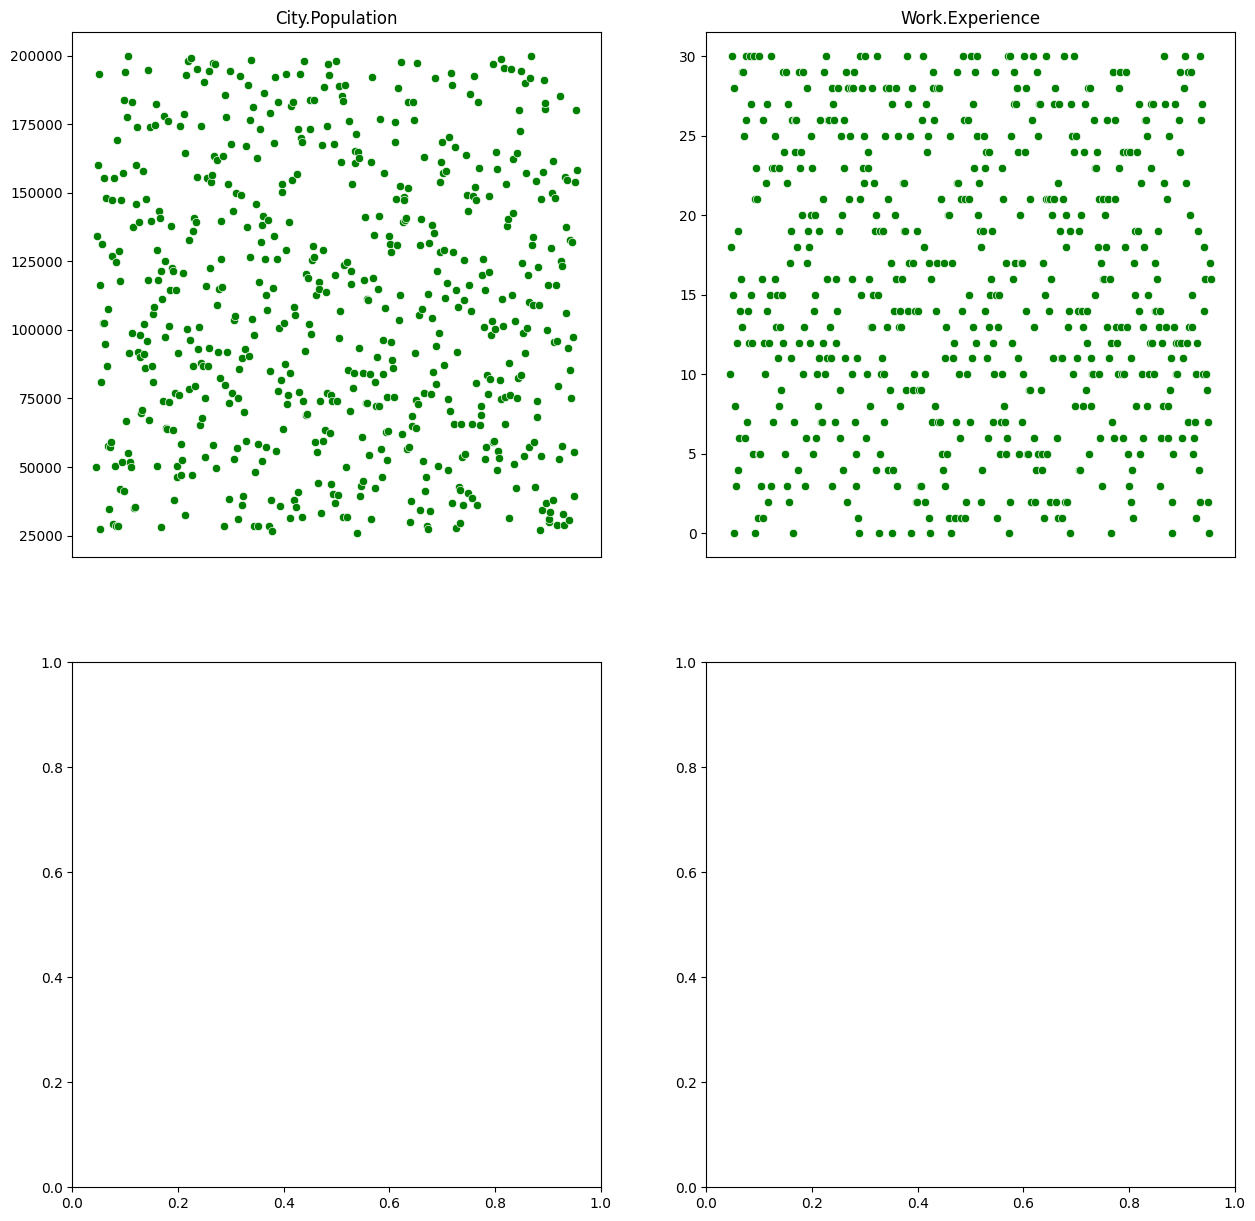

Row indices of potential outliers:
Int64Index([], dtype='int64')


In [17]:
#FUNCTION TO IDENTIFY OUTLIERS USING IQR METHOD
def iqr_outlier(x,factor):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    min_ = q1 - factor * iqr
    max_ = q3 + factor * iqr
    result_ = pd.Series([0] * len(x))
    result_[((x < min_) | (x > max_))] = 1
    return result_
#SCATTER PLOTS HIGHLIGHTING OUTLIERS CALCULATED USING IQR METHOD
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
row = col = 0
for n,i in enumerate(cont_df.columns):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    outliers = iqr_outlier(cont_df[i], 1.5)
   
   
    if sum(outliers) == 0:
        sns.scatterplot(x = np.arange(len(cont_df[i])), y = cont_df[i], ax = ax[row, col], legend=False, color = 'green')
    else:
        sns.scatterplot(x = np.arange(len(cont_df[i])), y = cont_df[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
    for x,y in zip(np.arange(len(cont_df[i]))[outliers == 1], cont_df[i][outliers == 1]):
        ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
    ax[row,col].set_ylabel("")
    ax[row,col].set_title(i)
    ax[row,col].xaxis.set_visible(False)
    if sum(outliers) > 0:
        ax[row,col].legend(ncol=2)
    col += 1
plt.show()

# Calculate the IQR for each variable
Q1 = cont_df.quantile(0.25)
Q3 = cont_df.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Identify potential outliers based on the IQR method
outliers = ((cont_df < (Q1 - IQR_multiplier * IQR)) | (cont_df > (Q3 + IQR_multiplier * IQR)))

# Get the row indices of potential outliers
row_indices = cont_df.index[outliers.any(axis=1)]

# Print the row indices of potential outliers
print("Row indices of potential outliers:")
print(row_indices)

### Using Z-Scores to detect the outliers

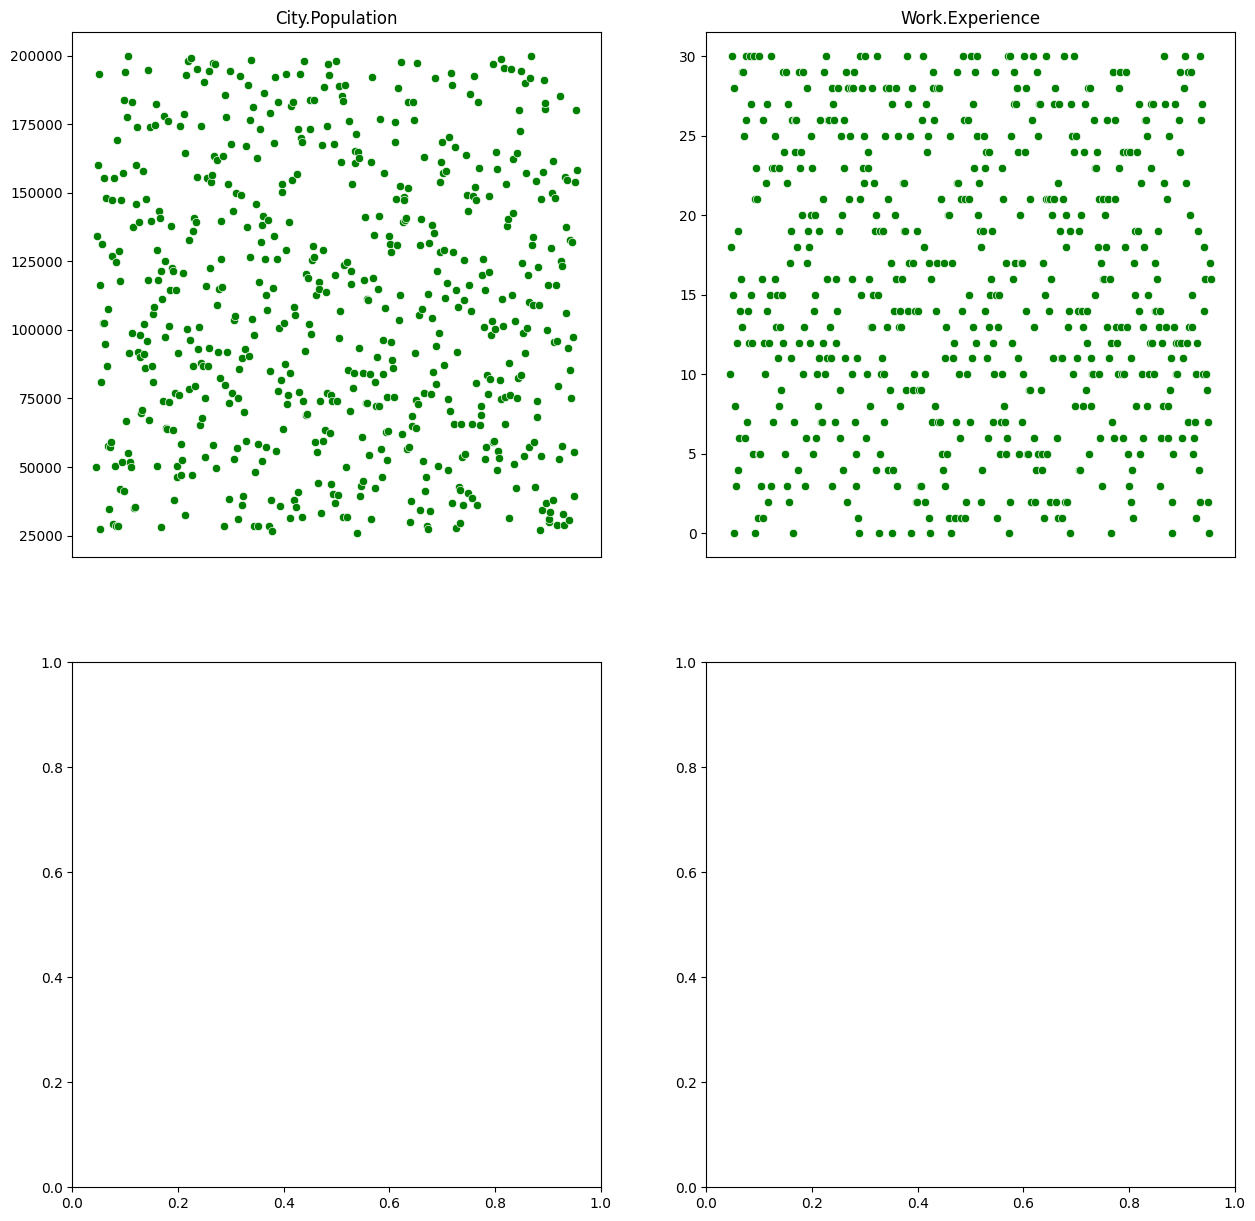

In [18]:
#FUNCTION TO DETECT OUTLIERS USING Z-SCORE METHOD
def zscore_outlier(x,lb,ub):
    zscore = ((x - x.mean()) / x.std()).copy()
    result_ = pd.Series([0] * len(x))
    result_[((zscore < lb) | (zscore > ub))] = 1
    return result_
#PLOTTING A SCATTER PLOT AND HIGHLIGHTING THE OUTLIERS DETECTED BY Z-SCORE METHOD
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
row = col = 0
for n,i in enumerate(cont_df.columns):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    outliers = zscore_outlier(cont_df[i], -3, 3)
   
    if sum(outliers) == 0:
        sns.scatterplot(x = np.arange(len(cont_df[i])), y = cont_df[i], ax = ax[row, col], legend=False, color = 'green')
    else:
        sns.scatterplot(x = np.arange(len(cont_df[i])), y = cont_df[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
    for x,y in zip(np.arange(len(cont_df[i]))[outliers == 1], cont_df[i][outliers == 1]):
        ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
    ax[row,col].set_ylabel("")
    ax[row,col].set_title(i)
    ax[row,col].xaxis.set_visible(False)
    if sum(outliers) > 0:
        ax[row,col].legend(ncol=2)
    col += 1

plt.show()


### Calculating the range for the continuous variable to check the outliers.

In [19]:
cont_df.describe()

,City.Population,Work.Experience
count,600.000000,600.000000
mean,108747.368333,15.558333
std,49850.075134,8.842147
min,25779.000000,0.000000
25%,66966.750000,8.000000
50%,106493.500000,15.000000
75%,150114.250000,24.000000
max,199778.000000,30.000000


### There are no outliers in the dataset.

In [20]:
# Correlation matrix to check the multi collinearity of the features
cont_df.corr()

,City.Population,Work.Experience
City.Population,1.000000,0.013135
Work.Experience,0.013135,1.000000


<AxesSubplot: >

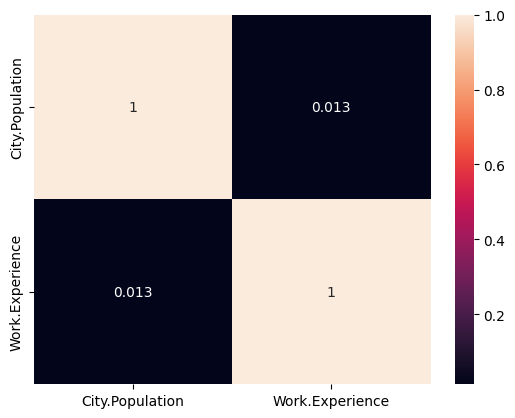

In [21]:
# Heatmaps for the given dataset.
sns.heatmap(cont_df.corr(), annot=True)

### None of the value is near or equal to 1 or -1 for the continuous features. Hence no multicolinearity present.

In [22]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

vif_results = calculate_vif(cont_df)  
print("VIF Results:")
print(vif_results)

VIF Results:
           feature      VIF
0  City.Population  2.69778
1  Work.Experience  2.69778


### VIF value for all the features is very low. Hence all the variables are significant and there is no presence of multicollinearity.

### From both the correlation matrix and the VIF value show that none of the feature depend on each other. Hence there is no multicollinearity present in the dataset. 

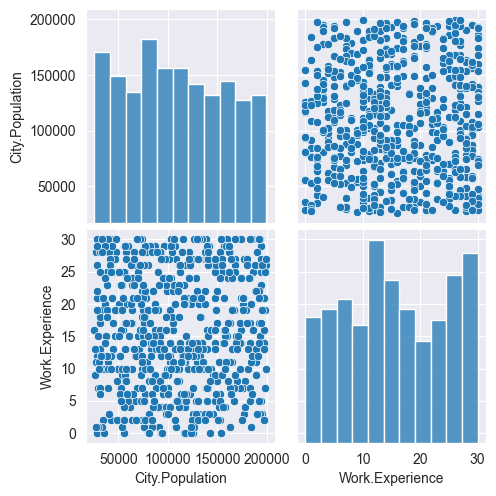

In [23]:
# Drawing Histogram to check the distribution of the data.
#Format the plot background and scatter plots for all the variables
sns.set_style(style='darkgrid')
sns.pairplot(cont_df)

### Most of the histogram shows that the features are not normally distributed.

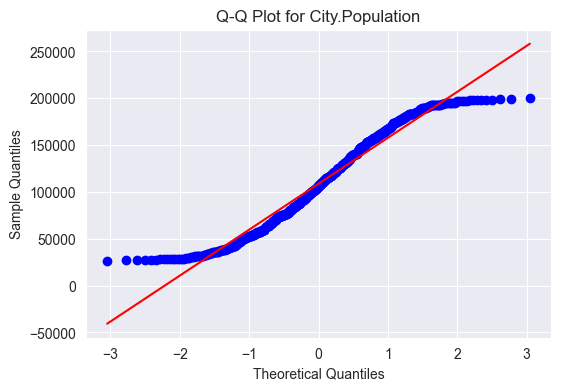

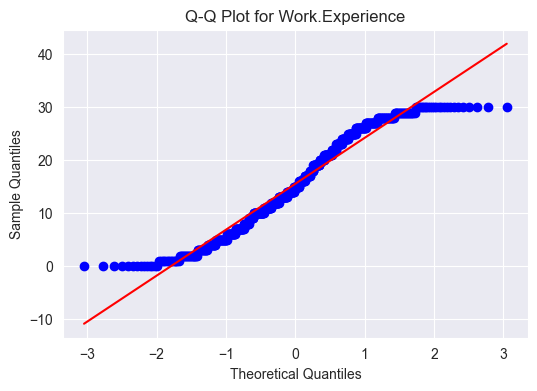

In [24]:
# Using Q-Q plot for checking the data distribution
# Create Q-Q plots for each variable in separate graphs
for col in cont_df.columns:
    plt.figure(figsize=(6, 4))
    stats.probplot(cont_df[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {col}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

## Most of the Q-Q plot shows that features are not normally distributed.
## Hence we can use Normalization for transformation. 

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the Normalization
min_max_scaler = MinMaxScaler()

# Fit and transform the data using standardization
normalized_data_minmax = min_max_scaler.fit_transform(cont_df)


# Create a new DataFrame with the standardized data
norm_df = pd.DataFrame(normalized_data_minmax, columns = cont_df.columns)

In [26]:
norm_df

,City.Population,Work.Experience
0,0.139472,0.333333
1,0.622394,0.600000
2,0.772568,1.000000
3,0.962563,0.500000
4,0.010081,0.933333
...,...,...
595,0.078811,0.233333
596,0.170058,0.066667
597,0.737240,0.000000
598,0.886810,0.566667


### Pre-processing of Training Categorical variable dataframe. 

In [27]:
cat_df.head(5)

,Undergrad,Marital.Status,Urban,Taxable.Income
0,NO,Single,YES,68833
1,YES,Divorced,YES,33700
2,NO,Married,YES,36925
3,YES,Single,YES,50190
4,NO,Married,NO,81002


In [30]:
# Replace 'desired_columns' with a list of column names for which you want to find unique values
desired_columns = ['Undergrad','Marital.Status', 'Urban']

# Create an empty dictionary to store unique values for each column
unique_values_dict = {}

# Loop through the desired columns and find unique values for each
for column in desired_columns:
    unique_values = cat_df[column].unique()
    unique_values_dict[column] = unique_values

In [31]:
unique_values_dict

{'Undergrad': array(['NO', 'YES'], dtype=object),
 'Marital.Status': array(['Single', 'Divorced', 'Married'], dtype=object),
 'Urban': array(['YES', 'NO'], dtype=object)}

### Applying Label encoder to Undergrad column as it has only two categories.

In [32]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
encoder = LabelEncoder()

# Fit and transform the dataset
encoded_labels = encoder.fit_transform(cat_df["Undergrad"])

# Add encoded labels to the DataFrame
cat_df["Undergrad"] = encoded_labels

### Applying Label encoder to Urban column as it has only two categories.

In [33]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
encoder = LabelEncoder()

# Fit and transform the dataset
encoded_labels = encoder.fit_transform(cat_df["Urban"])

# Add encoded labels to the DataFrame
cat_df["Urban"] = encoded_labels

In [34]:
cat_df

,Undergrad,Marital.Status,Urban,Taxable.Income
0,0,Single,1,68833
1,1,Divorced,1,33700
2,0,Married,1,36925
3,1,Single,1,50190
4,0,Married,0,81002
...,...,...,...,...
595,1,Divorced,1,76340
596,1,Divorced,1,69967
597,0,Divorced,1,47334
598,1,Married,0,98592


### Applying dummy variables on Marital.Status column.

In [35]:
import pandas as pd

# Create dummy variables for the 'Category' column
dummy_df = pd.get_dummies(cat_df['Marital.Status'], prefix='Marital.Status', drop_first=True)

# Drop the original 'Category' column from the original DataFrame
cat_df.drop(columns=['Marital.Status'], inplace=True)

# Concatenate the original DataFrame and the dummy DataFrame
cat_df = pd.concat([cat_df, dummy_df], axis=1)

In [36]:
cat_df

,Undergrad,Urban,Taxable.Income,Marital.Status_Married,Marital.Status_Single
0,0,1,68833,0,1
1,1,1,33700,0,0
2,0,1,36925,1,0
3,1,1,50190,0,1
4,0,0,81002,1,0
...,...,...,...,...,...
595,1,1,76340,0,0
596,1,1,69967,0,0
597,0,1,47334,0,0
598,1,0,98592,1,0


### Convert taxable income column from continuous variable to categorical variable.

In [38]:
# Define a function to categorize income
def categorize_income(income):
    if income <= 30000:
        return 'Risky'
    else:
        return 'Good'

# Apply the categorize_income function to create a new 'Income_Category' column
cat_df['Taxable.Income'] = cat_df['Taxable.Income'].apply(categorize_income)

# Display the resulting DataFrame
print(cat_df)

     Undergrad  Urban Taxable.Income  Marital.Status_Married  \
0            0      1           Good                       0   
1            1      1           Good                       0   
2            0      1           Good                       1   
3            1      1           Good                       0   
4            0      0           Good                       1   
..         ...    ...            ...                     ...   
595          1      1           Good                       0   
596          1      1           Good                       0   
597          0      1           Good                       0   
598          1      0           Good                       1   
599          0      0           Good                       0   

     Marital.Status_Single  
0                        1  
1                        0  
2                        0  
3                        1  
4                        0  
..                     ...  
595                      0  

In [40]:
# Rearrange the columns
cat_df = cat_df[['Undergrad', 'Urban', 'Marital.Status_Married', 'Marital.Status_Single', 'Taxable.Income']]

In [41]:
cat_df.head(2)

,Undergrad,Urban,Marital.Status_Married,Marital.Status_Single,Taxable.Income
0,0,1,0,1,Good
1,1,1,0,0,Good


### Applying label encoder on sales_cat column the target variable.

In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the target column
cat_df['Taxable.Income'] = label_encoder.fit_transform(cat_df['Taxable.Income'])

In [43]:
cat_df.head(2)

,Undergrad,Urban,Marital.Status_Married,Marital.Status_Single,Taxable.Income
0,0,1,0,1,0
1,1,1,0,0,0


### Mearging training normalized continuous variable dataframe and encoded dataframe. 

In [44]:
# Concatenate the original DataFrame and the encoded DataFrame
norm_final_df = pd.concat([norm_df, cat_df], axis=1)

In [45]:
norm_final_df

,City.Population,Work.Experience,Undergrad,Urban,Marital.Status_Married,Marital.Status_Single,Taxable.Income
0,0.139472,0.333333,0,1,0,1,0
1,0.622394,0.600000,1,1,0,0,0
2,0.772568,1.000000,0,1,1,0,0
3,0.962563,0.500000,1,1,0,1,0
4,0.010081,0.933333,0,0,1,0,0
...,...,...,...,...,...,...,...
595,0.078811,0.233333,1,1,0,0,0
596,0.170058,0.066667,1,1,0,0,0
597,0.737240,0.000000,0,1,0,0,0
598,0.886810,0.566667,1,0,1,0,0


### Mearging original continuous variable dataframe and encoded dataframe. 

In [47]:
# Concatenate the original DataFrame and the encoded DataFrame
org_final_df = pd.concat([cont_df, cat_df], axis=1)

In [48]:
org_final_df

,City.Population,Work.Experience,Undergrad,Urban,Marital.Status_Married,Marital.Status_Single,Taxable.Income
0,50047,10,0,1,0,1,0
1,134075,18,1,1,0,0,0
2,160205,30,0,1,1,0,0
3,193264,15,1,1,0,1,0
4,27533,28,0,0,1,0,0
...,...,...,...,...,...,...,...
595,39492,7,1,1,0,0,0
596,55369,2,1,1,0,0,0
597,154058,0,0,1,0,0,0
598,180083,17,1,0,1,0,0


# Model building

### Model building on normalized dataset.

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separate features (X) and target variable (y)
X = norm_final_df.drop('Taxable.Income', axis=1)
y = norm_final_df['Taxable.Income']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)

accuracy1 = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy1)
print("Classification Report:\n", report)


Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79        94
           1       0.18      0.15      0.17        26

    accuracy                           0.67       120
   macro avg       0.48      0.48      0.48       120
weighted avg       0.65      0.67      0.66       120



## Random search CV for model optimization. 

In [50]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the hyperparameter space to search
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(0, 11),
    'min_samples_split': np.arange(0, 11),
    'min_samples_leaf': np.arange(0, 11),
}

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    dt_classifier, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1
)

# Perform the random search
random_search.fit(X, y)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Print the best cross-validated score
print("Best Score (Cross-Validated Accuracy):", random_search.best_score_)


Best Hyperparameters: {'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 1, 'criterion': 'gini'}
Best Score (Cross-Validated Accuracy): 0.7933333333333332


## Grid search CV for model optimization. 

In [51]:
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 16),  # Range from 1 to 15 (inclusive)
    'min_samples_split': np.arange(2, 11),  # Range from 2 to 10 (inclusive)
    'min_samples_leaf': np.arange(1, 10),  # Range from 1 to 4 (inclusive)
}
# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    dt_classifier, param_grid=param_grid, cv=5, n_jobs=-1
)

# Perform the grid search
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best cross-validated score
print("Best Score (Cross-Validated Accuracy):", grid_search.best_score_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score (Cross-Validated Accuracy): 0.7933333333333332


## K-fold cross validation 

In [52]:
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 16),  # Range from 1 to 15 (inclusive)
    'min_samples_split': np.arange(2, 11),  # Range from 2 to 10 (inclusive)
    'min_samples_leaf': np.arange(1, 10),  # Range from 1 to 4 (inclusive)
}
# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV with k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    dt_classifier, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy'
)

# Perform the grid search
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best cross-validated score
print("Best Score (Cross-Validated Accuracy):", grid_search.best_score_)


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score (Cross-Validated Accuracy): 0.7933333333333332


## Both the hyper tuning method suggest the same values. Hence above are the optimized vales. 

# Final  model with optimum values.

In [53]:
from sklearn.tree import DecisionTreeClassifier

# Initialize a Decision Tree classifier with custom hyperparameters
final_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=1,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.7833333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88        94
           1       0.00      0.00      0.00        26

    accuracy                           0.78       120
   macro avg       0.39      0.50      0.44       120
weighted avg       0.61      0.78      0.69       120



## We can see that the accuracy of the model has increased from 66 to 78 percent. Hence the model is good and the hyperparameters are also optimized.

## Visualization of Tree 

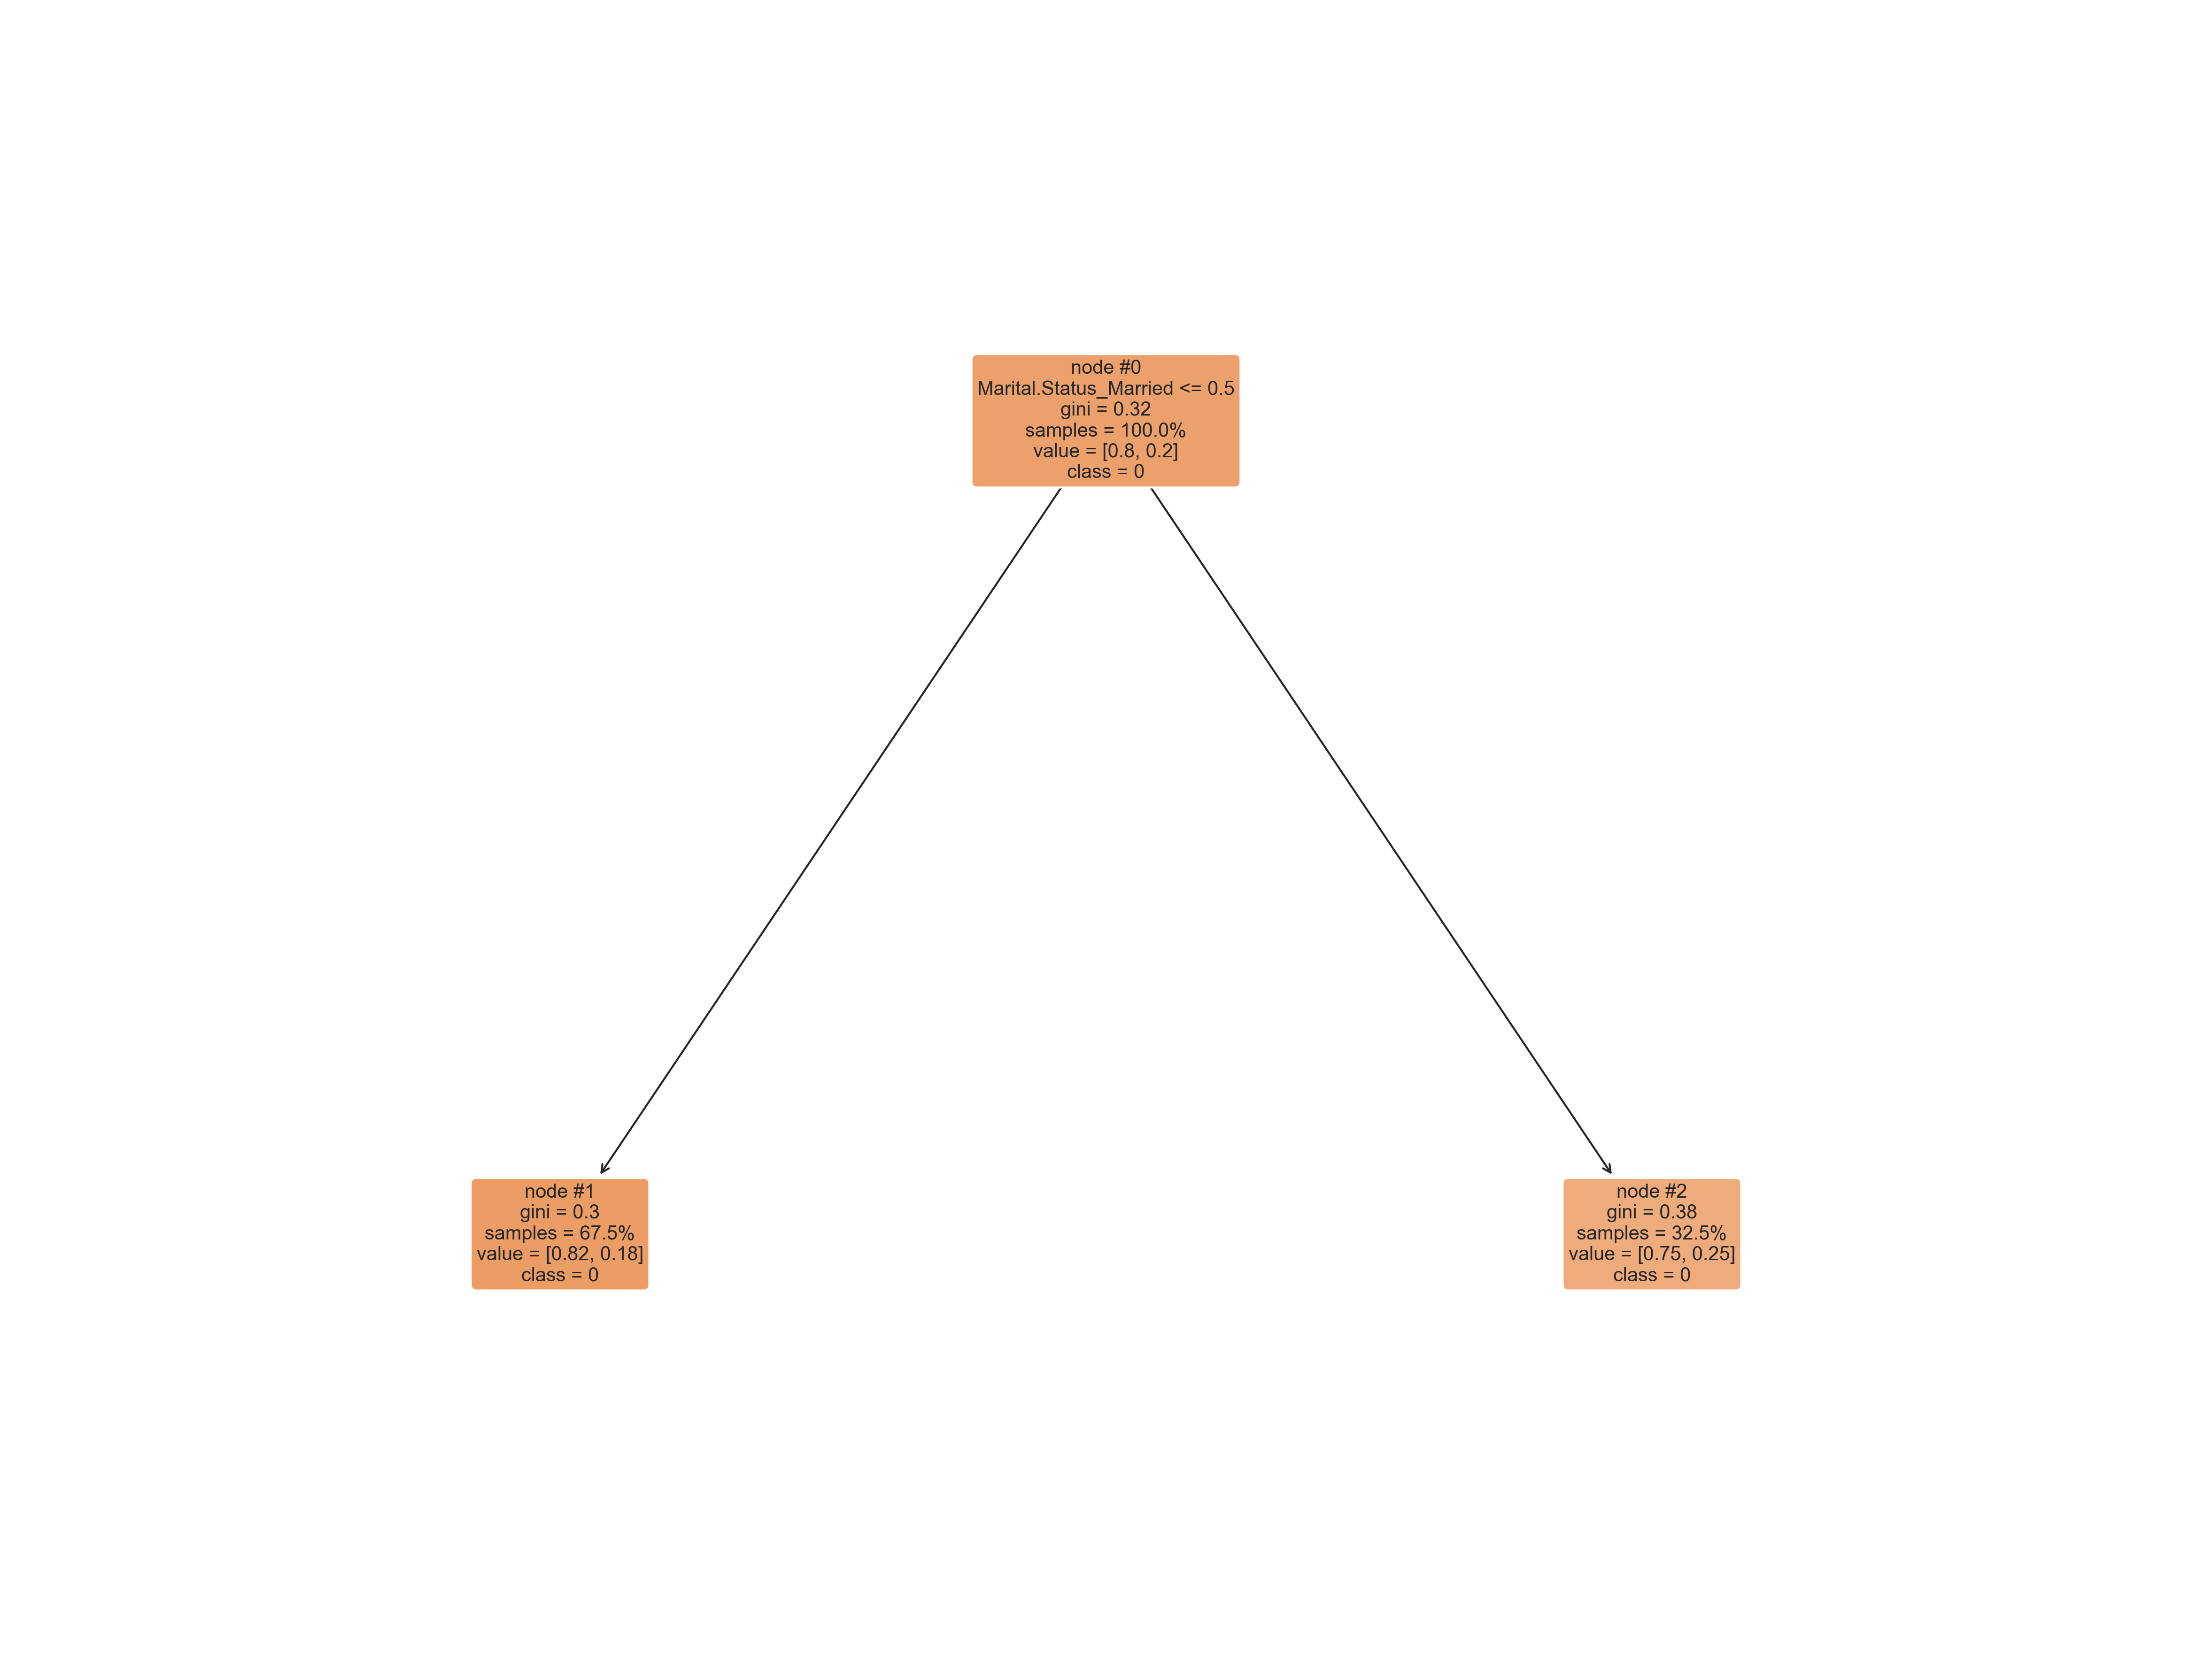

In [56]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree

# Initialize a Decision Tree classifier with custom hyperparameters
final_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=1,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

final_model.fit(X_train, y_train)

# Create a higher-resolution plot
plt.figure(figsize=(20, 15), dpi=300)

# Plot the decision tree for the final_model with customized node attributes
tree.plot_tree(
    final_model,  # Use final_model instead of dt_classifier
    filled=True,
    rounded=True,
    fontsize=10,
    node_ids=True,
    impurity=True,
    proportion=True,
    precision=2,
    feature_names=X.columns,
    class_names=[str(unique_class) for unique_class in y.unique()],  # Convert class names to strings
)

# Show the plot
plt.show()


### Confusion matrix for model accuracy.

In [57]:
# Confusion Matrix for the model accuracy
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[94  0]
 [26  0]]


### Classification report for model performance

In [58]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        94
           1       0.00      0.00      0.00        26

    accuracy                           0.78       120
   macro avg       0.39      0.50      0.44       120
weighted avg       0.61      0.78      0.69       120

